In [1]:
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models as gensimvis  
from gensim.models.ldamulticore import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 
import matplotlib.gridspec as gridspec
import math

/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
random_state = 123456

In [3]:
df = pd.read_excel('final_cleaned_data.xlsx', index_col=0)
df[['C1', 'C2', 'C3']] = df[['C1', 'C2', 'C3']].astype(str)
df.head()

,C1,C2,C3,A1,A2,A3,ID,Link,C1_link,C2_link,C3_link
0,>anti-punctuationwhy should i care about punct...,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN
1,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN
2,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN
3,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,"Apparently, no English either.",DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN
4,no biology and chemistry,"Apparently, no English either.",im working on one in psychology and English,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN


In [4]:
df.shape

(12739, 11)

In [5]:
df['agg'] = df[['C1', 'C2', 'C3']].agg(' '.join, axis=1)
df['agg'].iloc[2]

'i have two PhDs dumb ass One in Anti-punctuation; the other in Palindromes? We’ll call you Dr. Awkward. no biology and chemistry'

In [6]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/conneryurkon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['agg'] = df['agg'].apply(simple_preprocess)
df['agg'] = df['agg'].apply(lambda x: [word for word in x if word not in stopwords])
df['agg'].iloc[0]

['anti',
 'punctuationwhy',
 'care',
 'punctuation',
 'internet',
 'one',
 'cares',
 'care',
 'fucking',
 'school',
 'ah',
 'get',
 'still',
 'young',
 'period',
 'yet',
 'two',
 'phds',
 'dumb',
 'ass']

In [8]:
dictionary = Dictionary(df['agg'])
dictionary.token2id

{'ah': 0,
 'anti': 1,
 'ass': 2,
 'care': 3,
 'cares': 4,
 'dumb': 5,
 'fucking': 6,
 'get': 7,
 'internet': 8,
 'one': 9,
 'period': 10,
 'phds': 11,
 'punctuation': 12,
 'punctuationwhy': 13,
 'school': 14,
 'still': 15,
 'two': 16,
 'yet': 17,
 'young': 18,
 'awkward': 19,
 'call': 20,
 'dr': 21,
 'palindromes': 22,
 'biology': 23,
 'chemistry': 24,
 'apparently': 25,
 'either': 26,
 'english': 27,
 'im': 28,
 'psychology': 29,
 'working': 30,
 'actually': 31,
 'amount': 32,
 'apart': 33,
 'banner': 34,
 'bruce': 35,
 'bruh': 36,
 'comment': 37,
 'degrees': 38,
 'depending': 39,
 'even': 40,
 'expert': 41,
 'far': 42,
 'fields': 43,
 'going': 44,
 'high': 45,
 'human': 46,
 'insane': 47,
 'level': 48,
 'like': 49,
 'made': 50,
 'mean': 51,
 'much': 52,
 'multiple': 53,
 'offhand': 54,
 'people': 55,
 'phd': 56,
 'plausible': 57,
 'research': 58,
 'specialization': 59,
 'takes': 60,
 'well': 61,
 'bad': 62,
 'brethren': 63,
 'clan': 64,
 'feel': 65,
 'fuck': 66,
 'also': 67,
 'amab':

In [9]:
corpus = [dictionary.doc2bow(text) for text in df['agg']]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1)]

In [10]:
perplexities = []
coherences = []

for num_topics in range(3, 16):
    lda_model = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        random_state=random_state
    )
    perplexities.append(lda_model.log_perplexity(corpus))
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherences.append(coherence_model.get_coherence())

Text(0.5, 1.0, 'Number of Topics vs. Coherence Score')

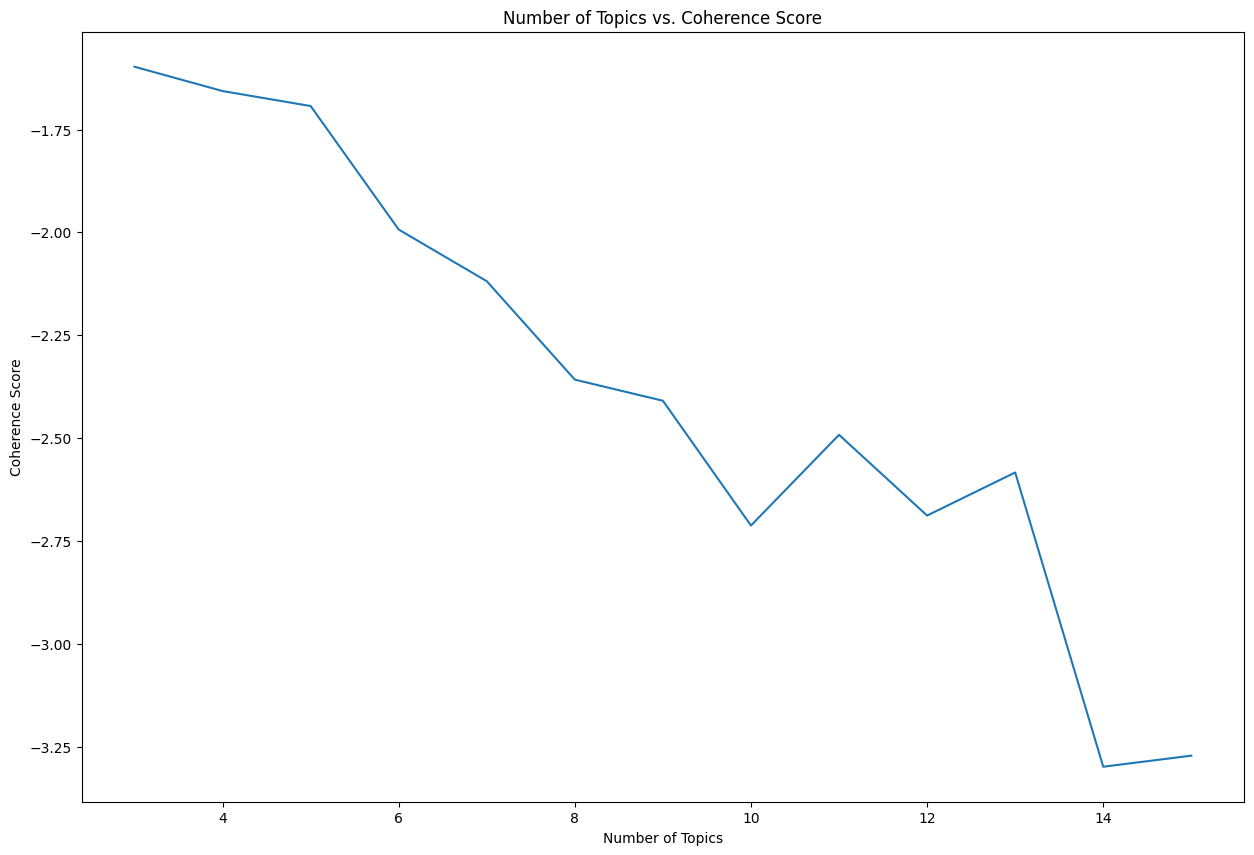

In [11]:
# higher is better

plt.figure(figsize=(15, 10))
plt.plot(range(3, 16), coherences)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Number of Topics vs. Coherence Score")

Text(0.5, 1.0, 'Number of Topics vs. Log Perplexity')

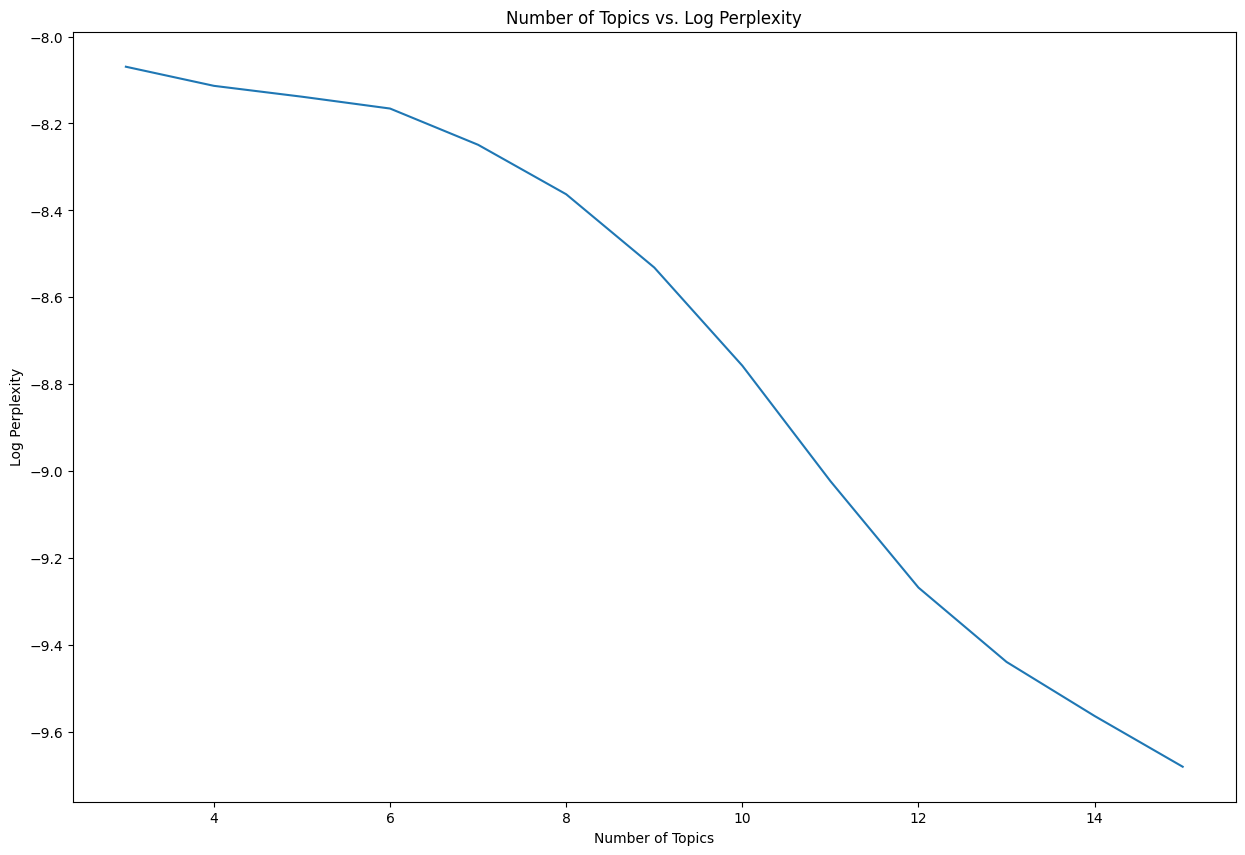

In [12]:
# lower is better

plt.figure(figsize=(15, 10))
plt.plot(range(3, 16), perplexities)
plt.xlabel("Number of Topics")
plt.ylabel("Log Perplexity")
plt.title("Number of Topics vs. Log Perplexity")

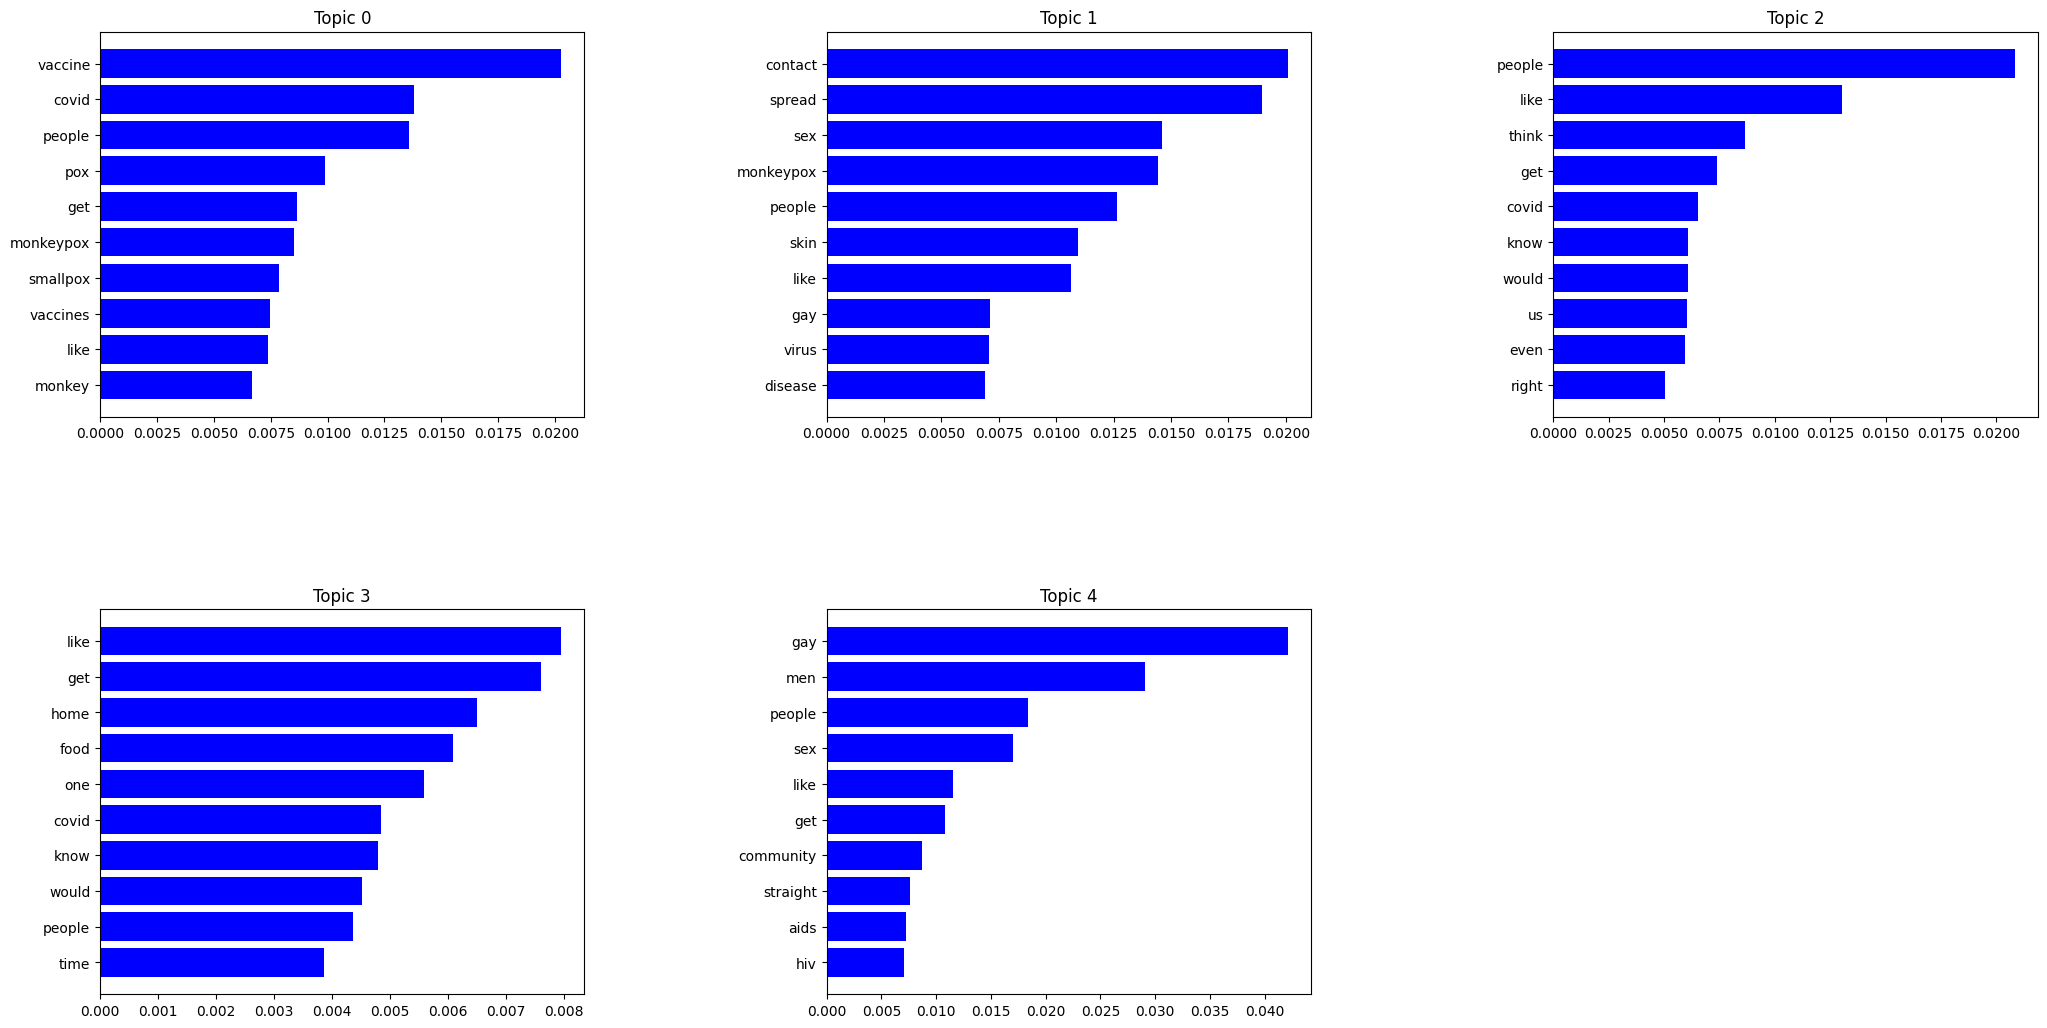

In [31]:
NUM_TOPICS = 5
lda_model = LdaModel(
        corpus=corpus,
        num_topics=NUM_TOPICS,
        id2word=dictionary,
        random_state=random_state + 6 # 2
)

def plot_top_words(lda=lda_model, nb_topics=NUM_TOPICS, nb_words=10):
    top_words = [[word for word, _ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _, beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(NUM_TOPICS)) + 1, round(math.sqrt(NUM_TOPICS)) + 1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(25, 20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center', color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic " + str(i))
        
plot_top_words(lda=lda_model)

In [32]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.049554  0.030344       1        1  25.011330
1     -0.110267 -0.028243       2        1  23.005135
0      0.015914 -0.115491       3        1  20.235055
4     -0.099482  0.078519       4        1  17.624905
3      0.144283  0.034870       5        1  14.123575, topic_info=         Term         Freq        Total Category  logprob  loglift
171       gay  6641.000000  6641.000000  Default  30.0000  30.0000
174       men  4362.000000  4362.000000  Default  29.0000  29.0000
1069  contact  3450.000000  3450.000000  Default  28.0000  28.0000
188   vaccine  3253.000000  3253.000000  Default  27.0000  27.0000
319       sex  4613.000000  4613.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
67       also   262.567608  3173.914242   Topic5  -5.8905  -0.5349
634    person   241.011259  1602.932601   Topic5  -5.9762   0.0626
488       got   238.487954  1724.928924   Topic5  -5.9867  -0.0213
657     thing   236.741695  1630.377681   Topic5  -5.9941   0.0277
1026       us   237.324562  2325.424526   Topic5  -5.9916  -0.3249

[464 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
4717       1  0.015881     acam
4717       2  0.015881     acam
4717       3  0.936977     acam
4717       4  0.015881     acam
4717       5  0.015881     acam
...      ...       ...      ...
466        2  0.080998    years
466        3  0.485987    years
466        4  0.032711    years
466        5  0.167448    years
10447      5  0.963166  zombies

[1264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

In [33]:
lda_model.print_topics()

[(0,
  '0.020*"vaccine" + 0.014*"covid" + 0.014*"people" + 0.010*"pox" + 0.009*"get" + 0.009*"monkeypox" + 0.008*"smallpox" + 0.007*"vaccines" + 0.007*"like" + 0.007*"monkey"'),
 (1,
  '0.020*"contact" + 0.019*"spread" + 0.015*"sex" + 0.014*"monkeypox" + 0.013*"people" + 0.011*"skin" + 0.011*"like" + 0.007*"gay" + 0.007*"virus" + 0.007*"disease"'),
 (2,
  '0.021*"people" + 0.013*"like" + 0.009*"think" + 0.007*"get" + 0.007*"covid" + 0.006*"know" + 0.006*"would" + 0.006*"us" + 0.006*"even" + 0.005*"right"'),
 (3,
  '0.008*"like" + 0.008*"get" + 0.007*"home" + 0.006*"food" + 0.006*"one" + 0.005*"covid" + 0.005*"know" + 0.005*"would" + 0.004*"people" + 0.004*"time"'),
 (4,
  '0.042*"gay" + 0.029*"men" + 0.018*"people" + 0.017*"sex" + 0.012*"like" + 0.011*"get" + 0.009*"community" + 0.008*"straight" + 0.007*"aids" + 0.007*"hiv"')]

In [55]:
def get_topic_assignment(idx):
    return max(lda_model[corpus[idx]], key=lambda x: x[1])[0]

In [56]:
df['topic'] = [get_topic_assignment(idx) for idx in range(len(df.index))]

In [57]:
df.head()

,C1,C2,C3,A1,A2,A3,ID,Link,C1_link,C2_link,C3_link,agg,topic
0,>anti-punctuationwhy should i care about punct...,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[anti, punctuationwhy, care, punctuation, inte...",2
1,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN,"[ah, get, still, young, period, yet, two, phds...",3
2,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[two, phds, dumb, ass, one, anti, punctuation,...",2
3,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,"Apparently, no English either.",DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN,"[one, anti, punctuation, palindromes, call, dr...",2
4,no biology and chemistry,"Apparently, no English either.",im working on one in psychology and English,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[biology, chemistry, apparently, english, eith...",2


In [58]:
df['topic'].value_counts()

2    3579
1    2505
0    2414
4    2158
3    2083
Name: topic, dtype: int64

In [ ]:
df.to_excel(../lda/v2/)